# Exploring HDF5 - HEC-RAS model
This notebook is to read the data from hdf5 file (HEC-RAS model) and extract the data.


In [ ]:
#General libraries
import h5py
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math


In [ ]:
# === INPUT FILES ===
#hdf_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\HDF\Shel_2024.hdf"
hdf5_file_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\HDF\v5.p67.hdf"
shapefile_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\HDF\GMU_stations35.shp"
output_folder = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\HDF\output_depth_profiles"


In [ ]:
base_path = "Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas"

with h5py.File(hdf5_file_path, "r") as f:
    area_name = list(f[base_path].keys())[0]
    print(f"✅ Flow area: {area_name}\n")
    print("🔍 Available datasets:")
    for item in f[f"{base_path}/{area_name}"].keys():
        print(" -", item)


✅ Flow area: VA20230620195713

🔍 Available datasets:
 - Boundary Conditions
 - Computations
 - Face Velocity
 - Water Surface


In [ ]:
# Define the path to your HEC-RAS HDF results file
def explore_hdf5(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"[DATASET] {name} - shape: {obj.shape}, dtype: {obj.dtype}")
    elif isinstance(obj, h5py.Group):
        print(f"[GROUP]   {name}")

# Open the file in read mode
with h5py.File(hdf5_file_path, 'r') as hdf:
    print("📁 Exploring HEC-RAS HDF File Structure:")
    hdf.visititems(explore_hdf5)


📁 Exploring HEC-RAS HDF5 File Structure:
[GROUP]   Event Conditions
[GROUP]   Event Conditions/Unsteady
[GROUP]   Event Conditions/Unsteady/Boundary Conditions
[GROUP]   Event Conditions/Unsteady/Boundary Conditions/Stage Hydrographs
[DATASET] Event Conditions/Unsteady/Boundary Conditions/Stage Hydrographs/2D: VA20230620195713 BCLine: BC Line 1 - shape: (53, 2), dtype: float32
[GROUP]   Event Conditions/Unsteady/Initial Conditions
[GROUP]   Geometry
[GROUP]   Geometry/2D Flow Area Break Lines
[DATASET] Geometry/2D Flow Area Break Lines/Attributes - shape: (8,), dtype: [('Name', 'S32'), ('Cell Spacing Near', '<f4'), ('Cell Spacing Far', '<f4'), ('Near Repeats', '<i4'), ('Protection Radius', 'u1')]
[DATASET] Geometry/2D Flow Area Break Lines/Polyline Info - shape: (8, 4), dtype: int32
[DATASET] Geometry/2D Flow Area Break Lines/Polyline Parts - shape: (8, 2), dtype: int32
[DATASET] Geometry/2D Flow Area Break Lines/Polyline Points - shape: (482, 2), dtype: float64
[GROUP]   Geometry/2D F

## Plot depth profile for one cell to test

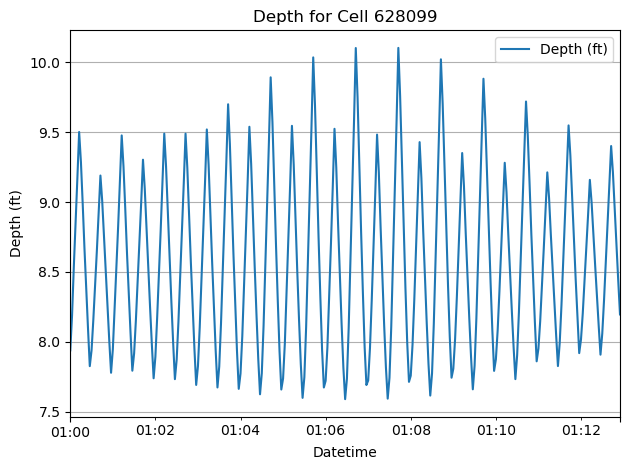

In [ ]:
cell_id = 628099  # Change this to your desired cell index

# === READ FROM HDF ===
with h5py.File(hdf5_file_path, 'r') as f:
    # 1. Time info (in minutes from start)
    time_minutes = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'][:]
    start_time_str = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][0].decode()
    start_datetime = datetime.strptime(start_time_str, '%d%b%Y %H:%M:%S')
    time_series = [start_datetime + timedelta(minutes=float(t)) for t in time_minutes]


    # 2. Water surface (elevation at each time step for 1 cell)
    ws = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/VA20230620195713/Water Surface'][:, cell_id]

    # 3. Minimum elevation for this cell (ground level)
    z_min = f['/Geometry/2D Flow Areas/VA20230620195713/Cells Minimum Elevation'][cell_id]

    # 4. Calculate depth
    depth = ws - z_min

# === ORGANIZE IN A DATAFRAME ===
df = pd.DataFrame({
    'Datetime': time_series,
    'Depth (ft)': depth
}).set_index('Datetime')

# === EXPORT TO CSV ===
#df.to_csv(f'depth_cell_{cell_id}.csv')
#print(f" Depth time series saved as 'depth_cell_{cell_id}.csv'")

# === PLOT ===
df.plot(title=f'Depth for Cell {cell_id}', ylabel='Depth (ft)', xlabel='Datetime')
plt.grid(True)
plt.tight_layout()
plt.show()


## Plotting depth profiles for all cells

Cross information
01= 628120
02= 627951
03= 627921
04= 628029
05= 627746
06= 627684
07= 627618
08= 627572
09= 627530
10= 627472
11= 627396
12= 627381
13= 635980
14= 635128
15= 636050
16= 635000
17= 634940
18= 627311
19= 634847
20= 636360
21= 694557
22= 845840
23= 827923
24= 814408
25= 660900
26= 647501
27= 634688
28= 634563
29= 636676
30= 627066
31= 634263


In [ ]:
# === USER INPUTS ===
cell_ids = [628120, 627951, 627921, 628029, 627746, 627684, 627618, 627572, 627530, 627472, 627396, 627381, 635980, 635128, 636050, 635000, 634940, 627311, 634847, 636360, 694557, 845840, 827923, 814408, 660900, 647501, 634688, 634563, 636676, 627066, 634263]  # Replace with your actual cell IDs

# === OPEN HDF FILE ===
with h5py.File(hdf5_file_path, 'r') as f:
    # 1. Get time info
    time_minutes = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'][:]
    start_str = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][0].decode()
    start_datetime = datetime.strptime(start_str, '%d%b%Y %H:%M:%S')
    time_index = [start_datetime + timedelta(minutes=float(t)) for t in time_minutes]

    # 2. Get full water surface matrix (time_steps x num_cells)
    ws_all = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/VA20230620195713/Water Surface'][:]

    # 3. Get all cell minimum elevations
    z_all = f['/Geometry/2D Flow Areas/VA20230620195713/Cells Minimum Elevation'][:]

    # 4. Build depth dataframe
    depth_data = {}
    for cid in cell_ids:
        ws = ws_all[:, cid]
        z = z_all[cid]
        depth = ws - z
        depth_data[f'Cell_{cid}'] = depth

# === CREATE FINAL DATAFRAME ===
depth_df = pd.DataFrame(depth_data, index=pd.to_datetime(time_index))
depth_df.index.name = 'Datetime'

# === SAVE TO CSV ===
#depth_df.to_csv('depth_multiple_cells.csv')
#print("✅ Saved: depth_multiple_cells.csv")

# === OPTIONAL: Plot First Cell
#depth_df.iloc[:, 0].plot(title=f'Depth Time Series for Cell {cell_ids[0]}', ylabel='Depth (ft)', xlabel='DateTime')
#plt.grid(True)
#plt.tight_layout()
#plt.show()


## Plot cell's depth time series

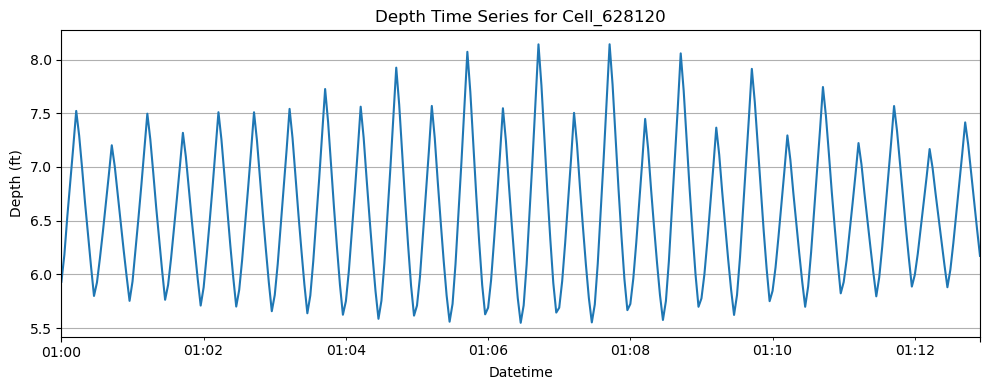

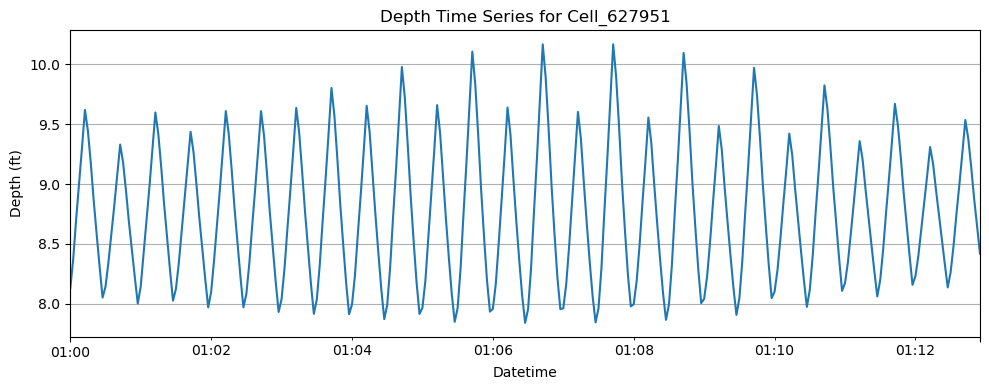

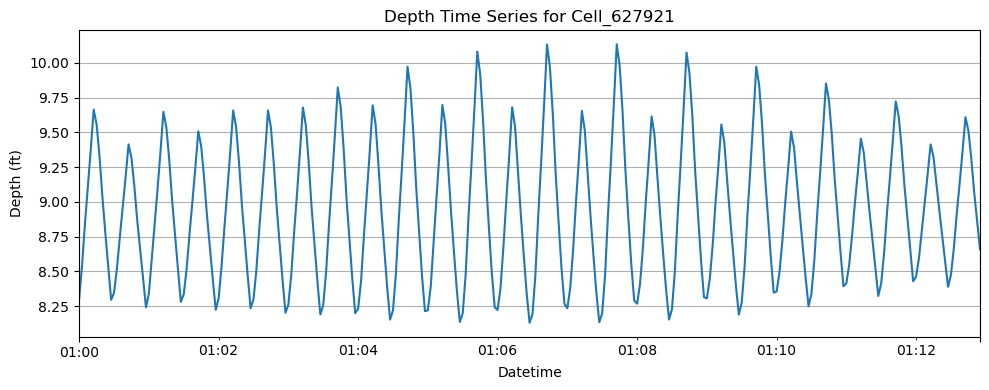

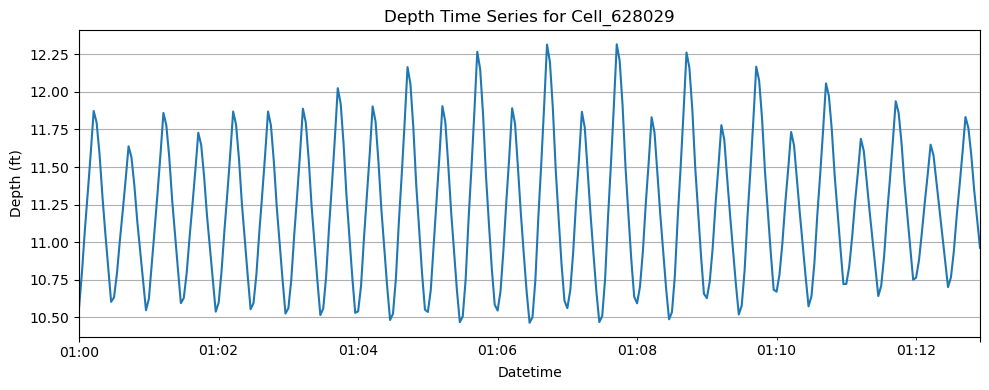

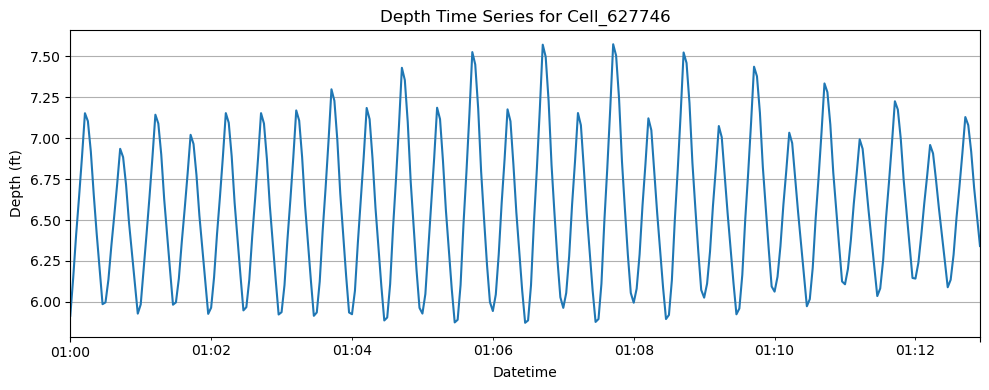

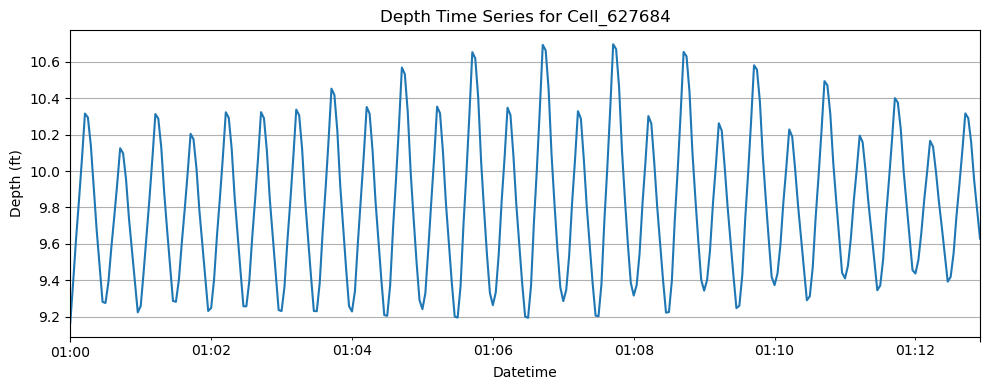

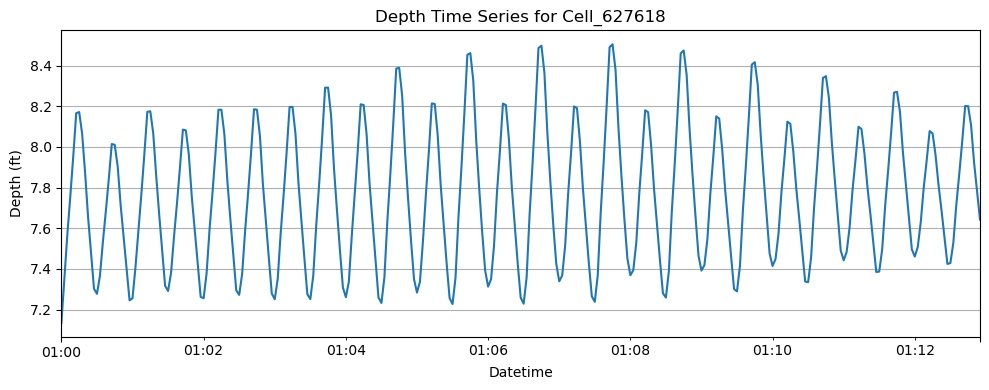

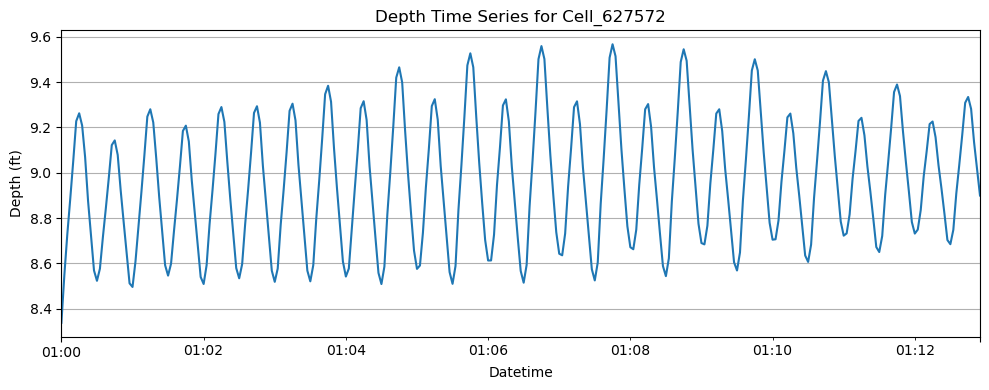

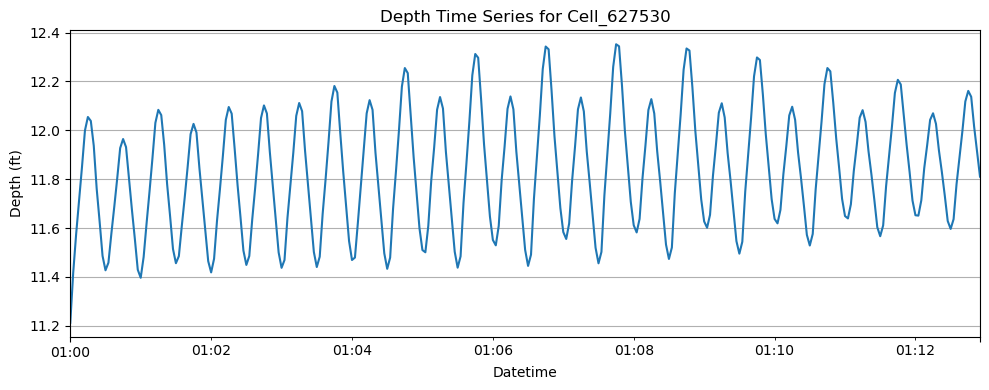

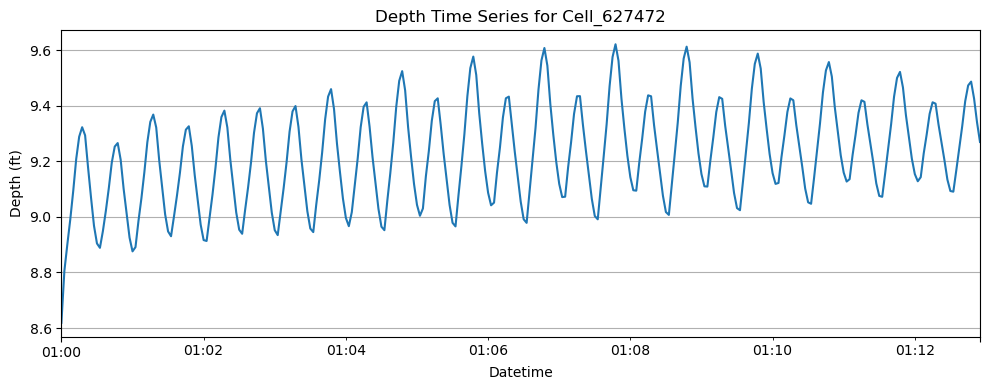

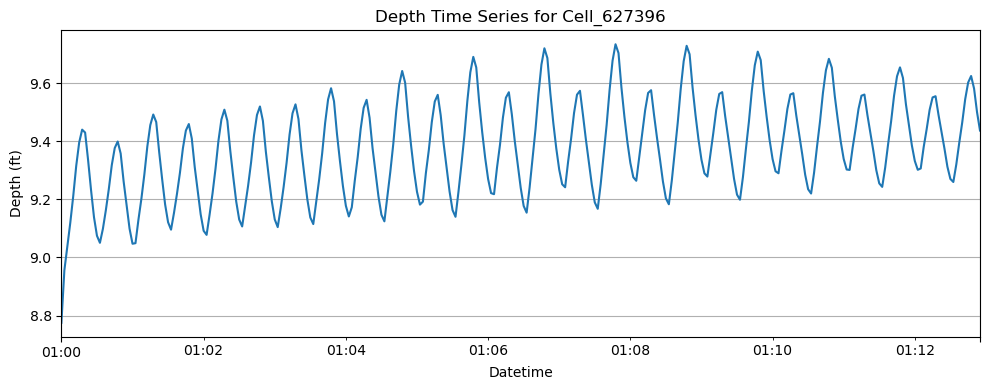

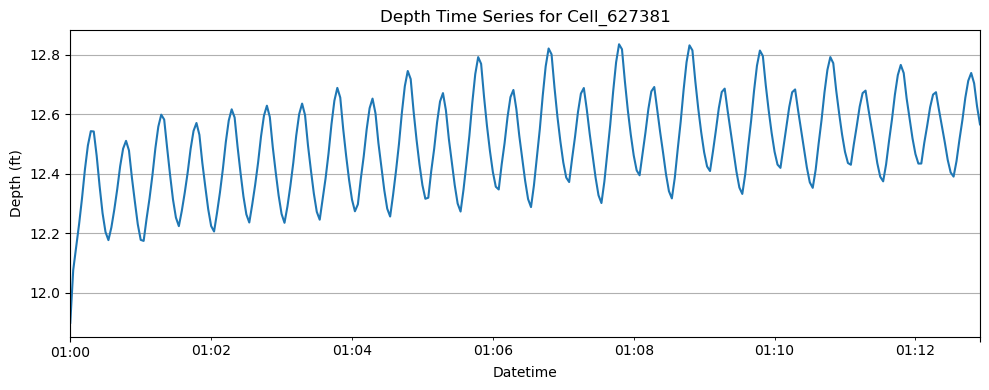

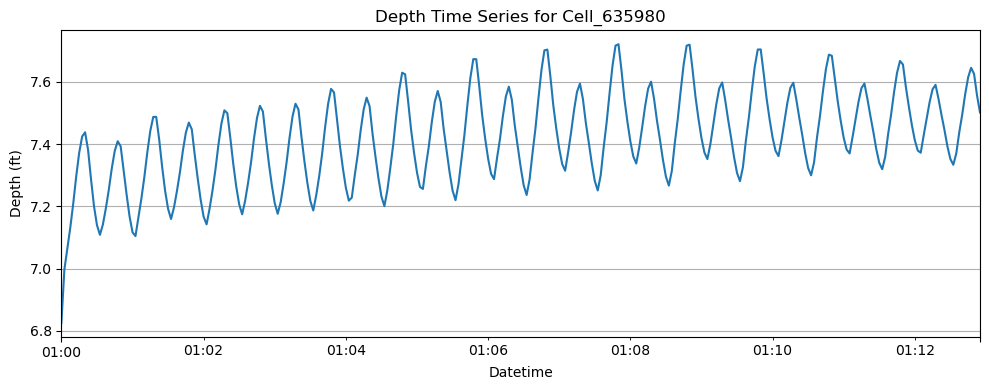

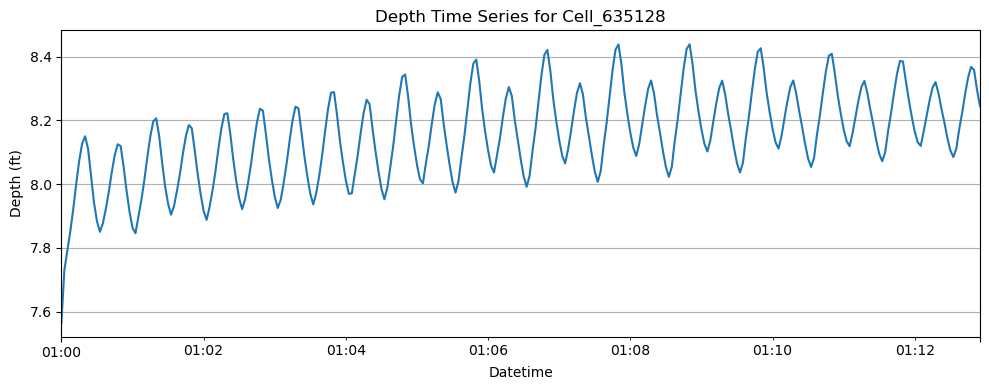

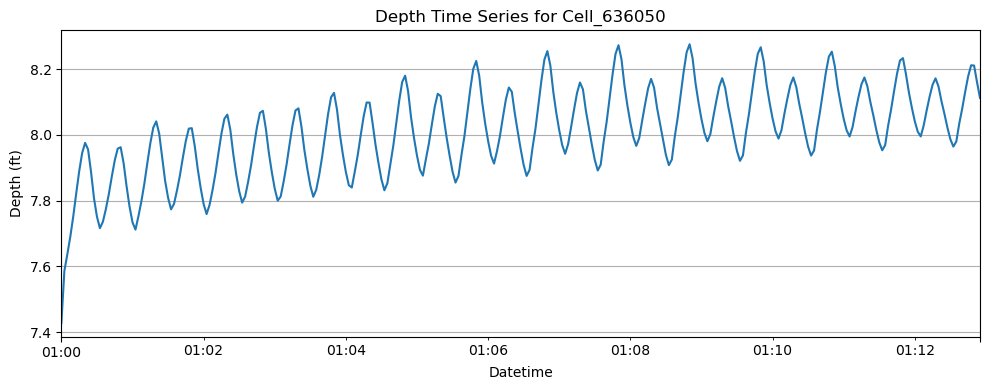

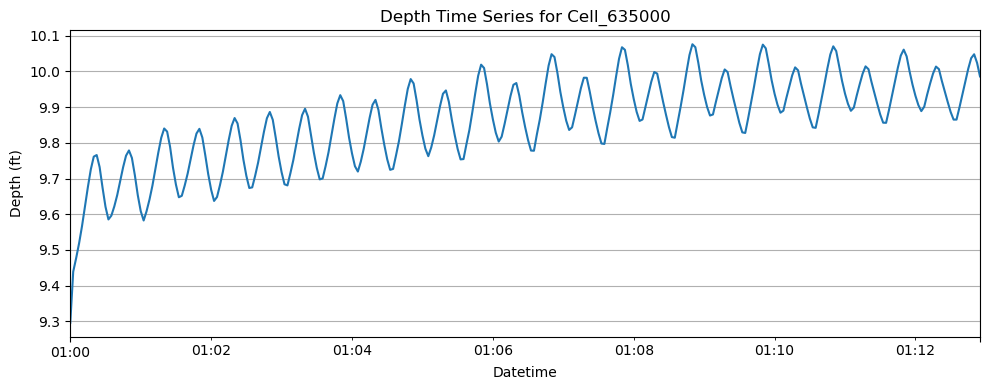

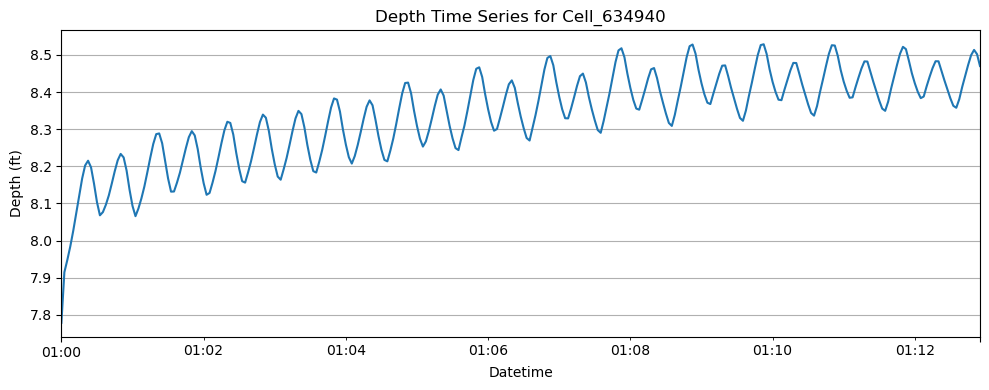

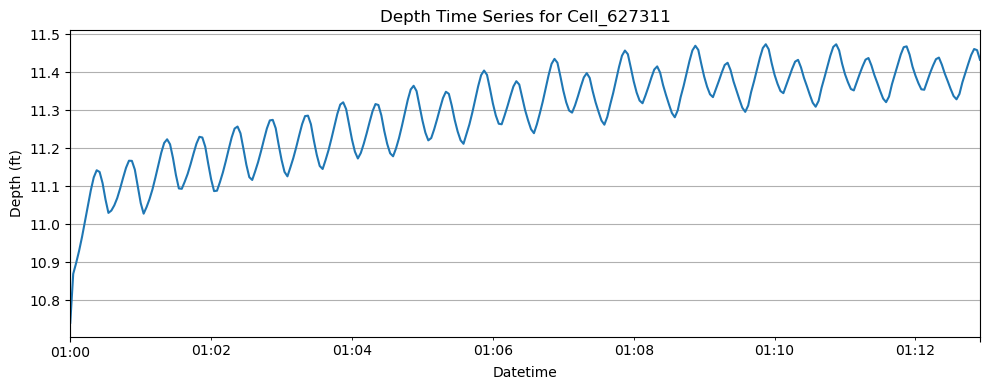

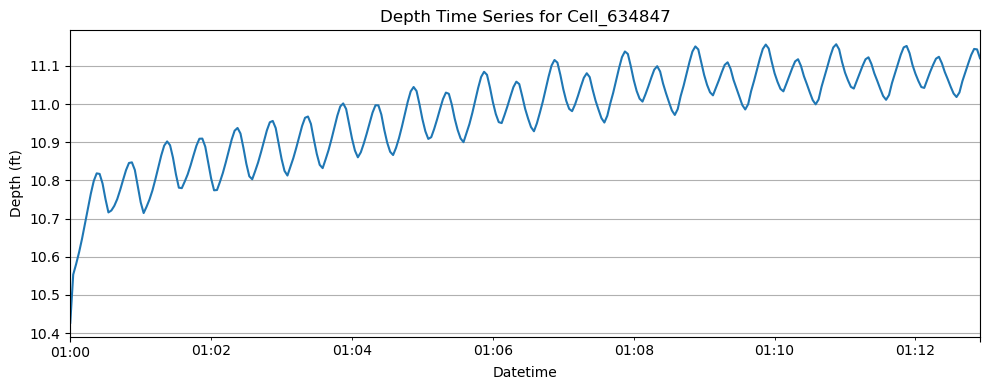

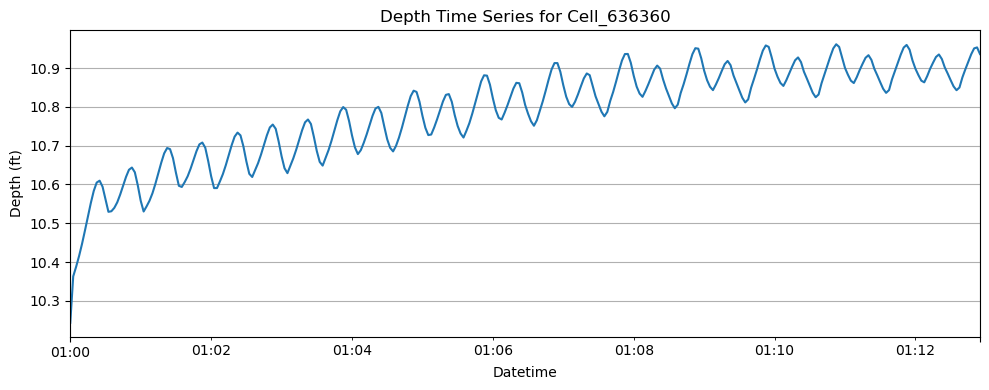

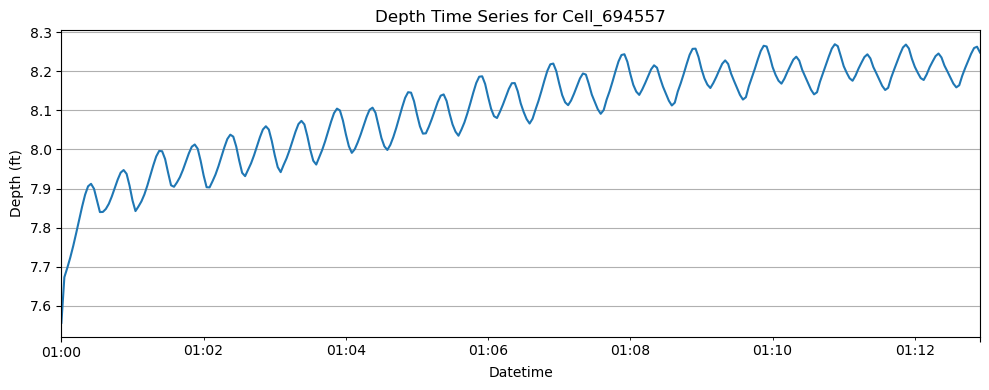

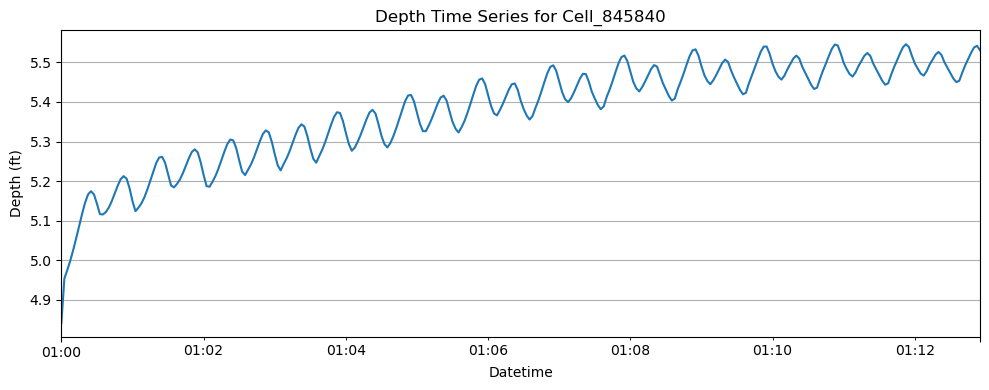

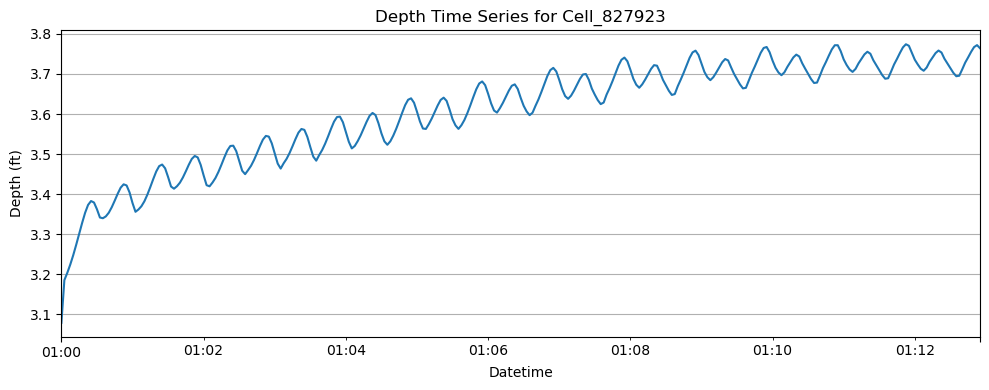

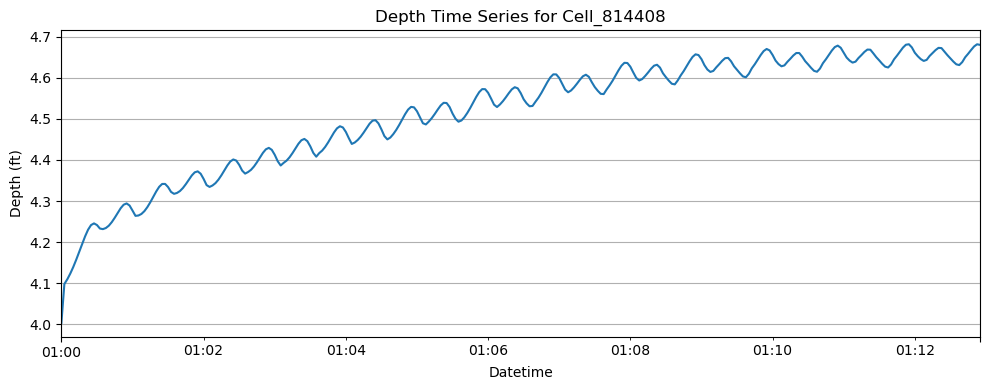

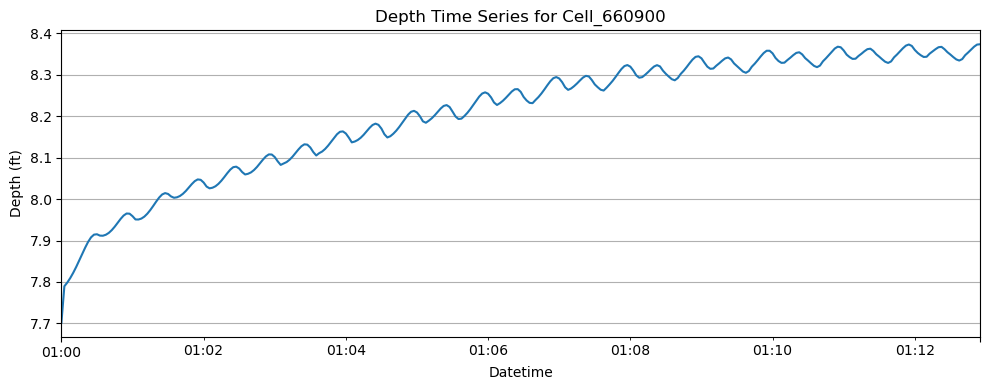

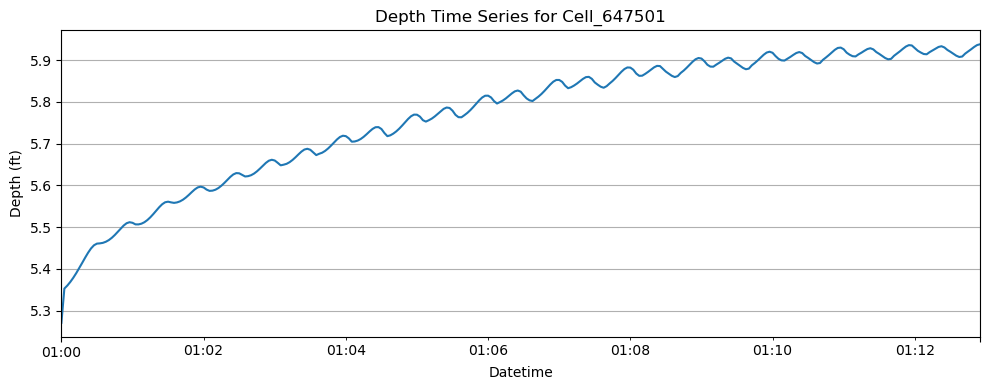

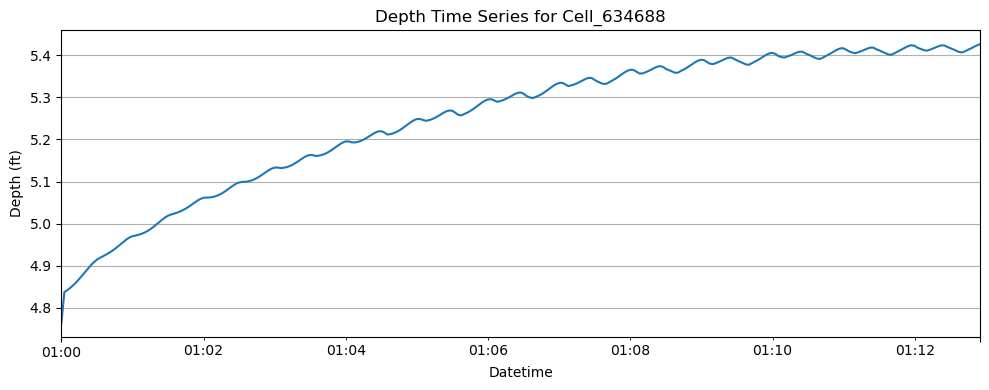

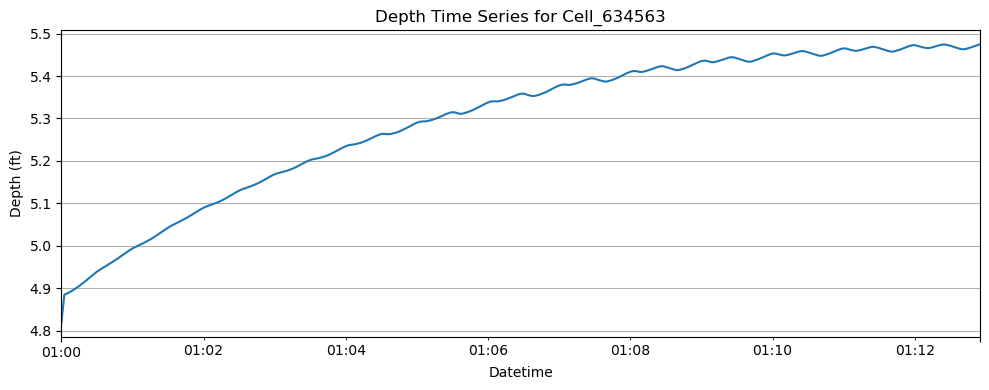

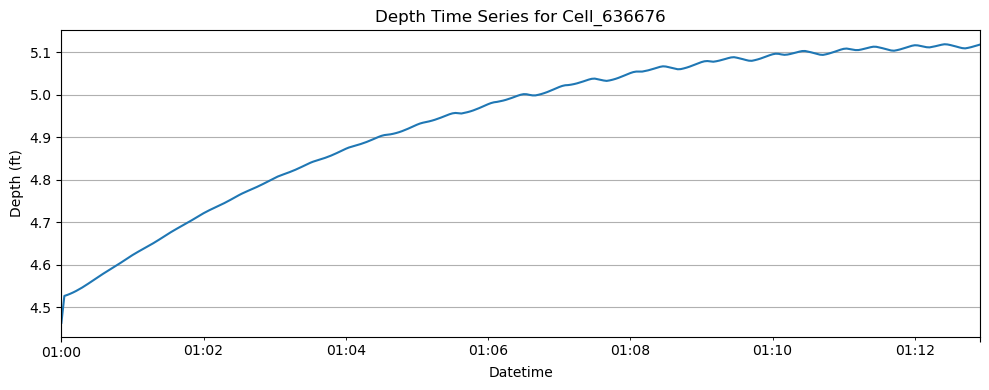

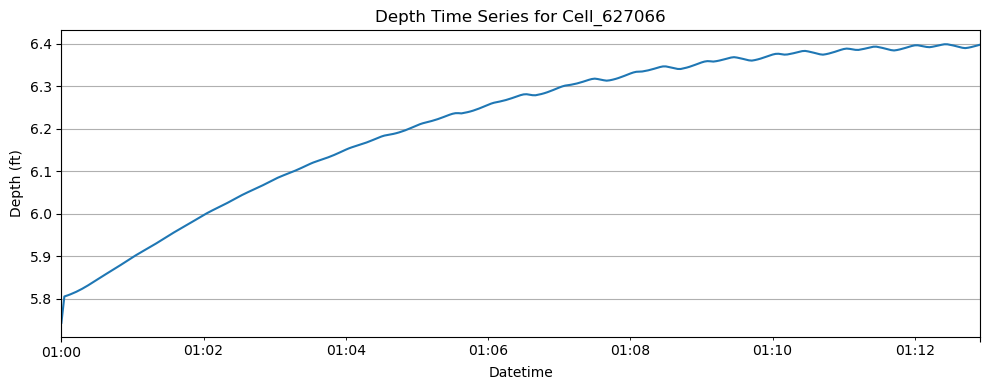

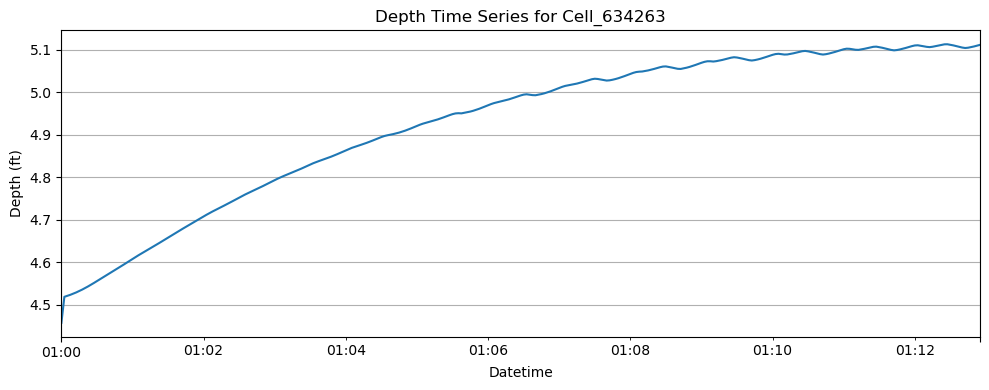

In [ ]:
for col in depth_df.columns:
    plt.figure(figsize=(10, 4))
    depth_df[col].plot(title=f'Depth Time Series for {col}', ylabel='Depth (ft)', xlabel='Datetime')
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f'{col}_depth_plot.png')  # Optional: Save each plot as PNG
    plt.show()


### Plot all in one figure

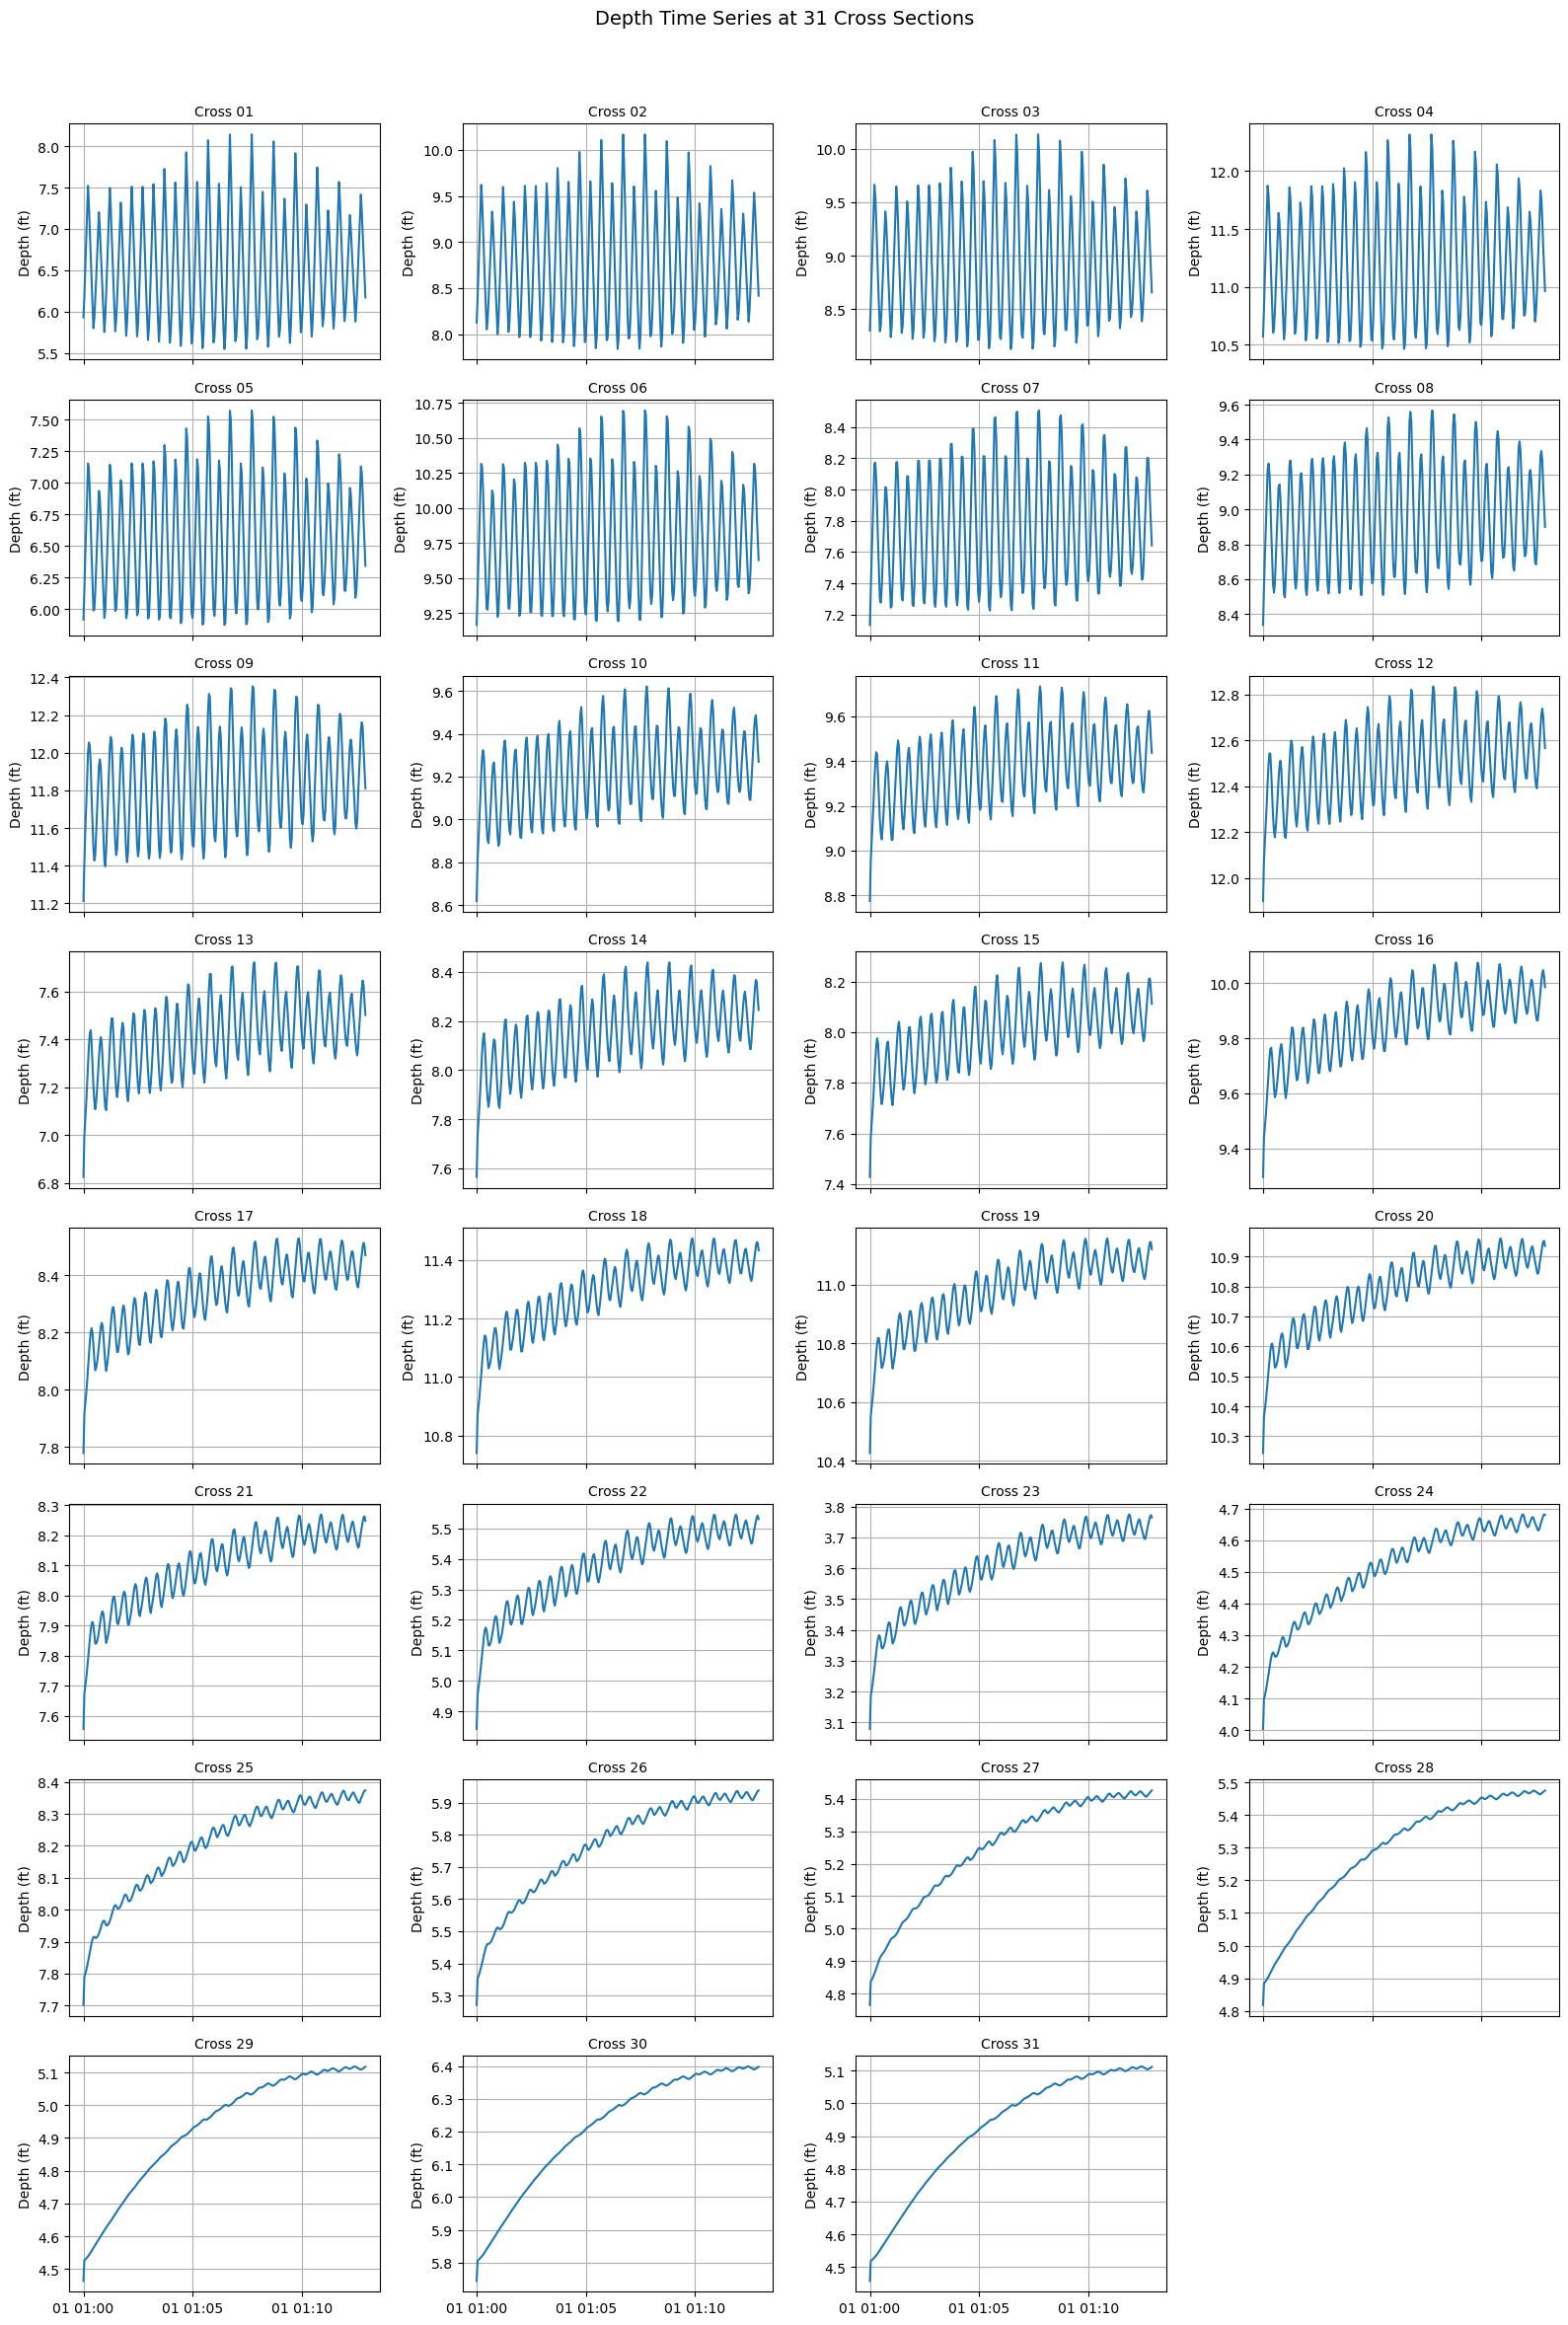

In [ ]:
# === Mapping Cell ID → Cross Section Name ===
cell_to_cross = {
    628120: "Cross 01",
    627951: "Cross 02",
    627921: "Cross 03",
    628029: "Cross 04",
    627746: "Cross 05",
    627684: "Cross 06",
    627618: "Cross 07",
    627572: "Cross 08",
    627530: "Cross 09",
    627472: "Cross 10",
    627396: "Cross 11",
    627381: "Cross 12",
    635980: "Cross 13",
    635128: "Cross 14",
    636050: "Cross 15",
    635000: "Cross 16",
    634940: "Cross 17",
    627311: "Cross 18",
    634847: "Cross 19",
    636360: "Cross 20",
    694557: "Cross 21",
    845840: "Cross 22",
    827923: "Cross 23",
    814408: "Cross 24",
    660900: "Cross 25",
    647501: "Cross 26",
    634688: "Cross 27",
    634563: "Cross 28",
    636676: "Cross 29",
    627066: "Cross 30",
    634263: "Cross 31"
}

# === Prepare Grid ===
num_cells = len(depth_df.columns)
cols = 4
rows = math.ceil(num_cells / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = axes.flatten()

# === Plot with Custom Titles ===
for i, col in enumerate(depth_df.columns):
    cell_id = int(col.replace("Cell_", ""))  # e.g., "Cell_627951" → 627951
    cross_name = cell_to_cross.get(cell_id, col)  # fallback to ID if not found

    ax = axes[i]
    ax.plot(depth_df.index, depth_df[col])
    ax.set_title(cross_name, fontsize=10)
    ax.set_ylabel("Depth (ft)")
    ax.grid(True)

# === Remove extra axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Depth Time Series at 31 Cross Sections", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
